## Playing with text

https://de.dariah.eu/tatom/working_with_text.html

In [1]:
import pandas as pd
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

from data_cleanup import base_stopwords

import settings
import psycopg2
import psycopg2.extras

In [2]:
conn = psycopg2.connect('dbname={}'.format(settings.DATABASE))
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
cur.execute('SELECT * FROM tweets')
tweets = cur.fetchall()
usernames = [tw['screen_name'] for tw in tweets]
texts = [tw['raw_text'] for tw in tweets]

### Extract word frequencies

In [3]:
vectorizer = text.CountVectorizer(input='content',
                                  strip_accents='unicode',
                                  stop_words=base_stopwords)
dtm = vectorizer.fit_transform(texts).toarray()

### Visualizing distances

A general approach to visualizing distances is to assign a point in a plane to each text, making sure that the distance between points is proportional to the pairwise distances we calculated. This kind of visualization is common enough that it has a name, “multidimensional scaling” (MDS).

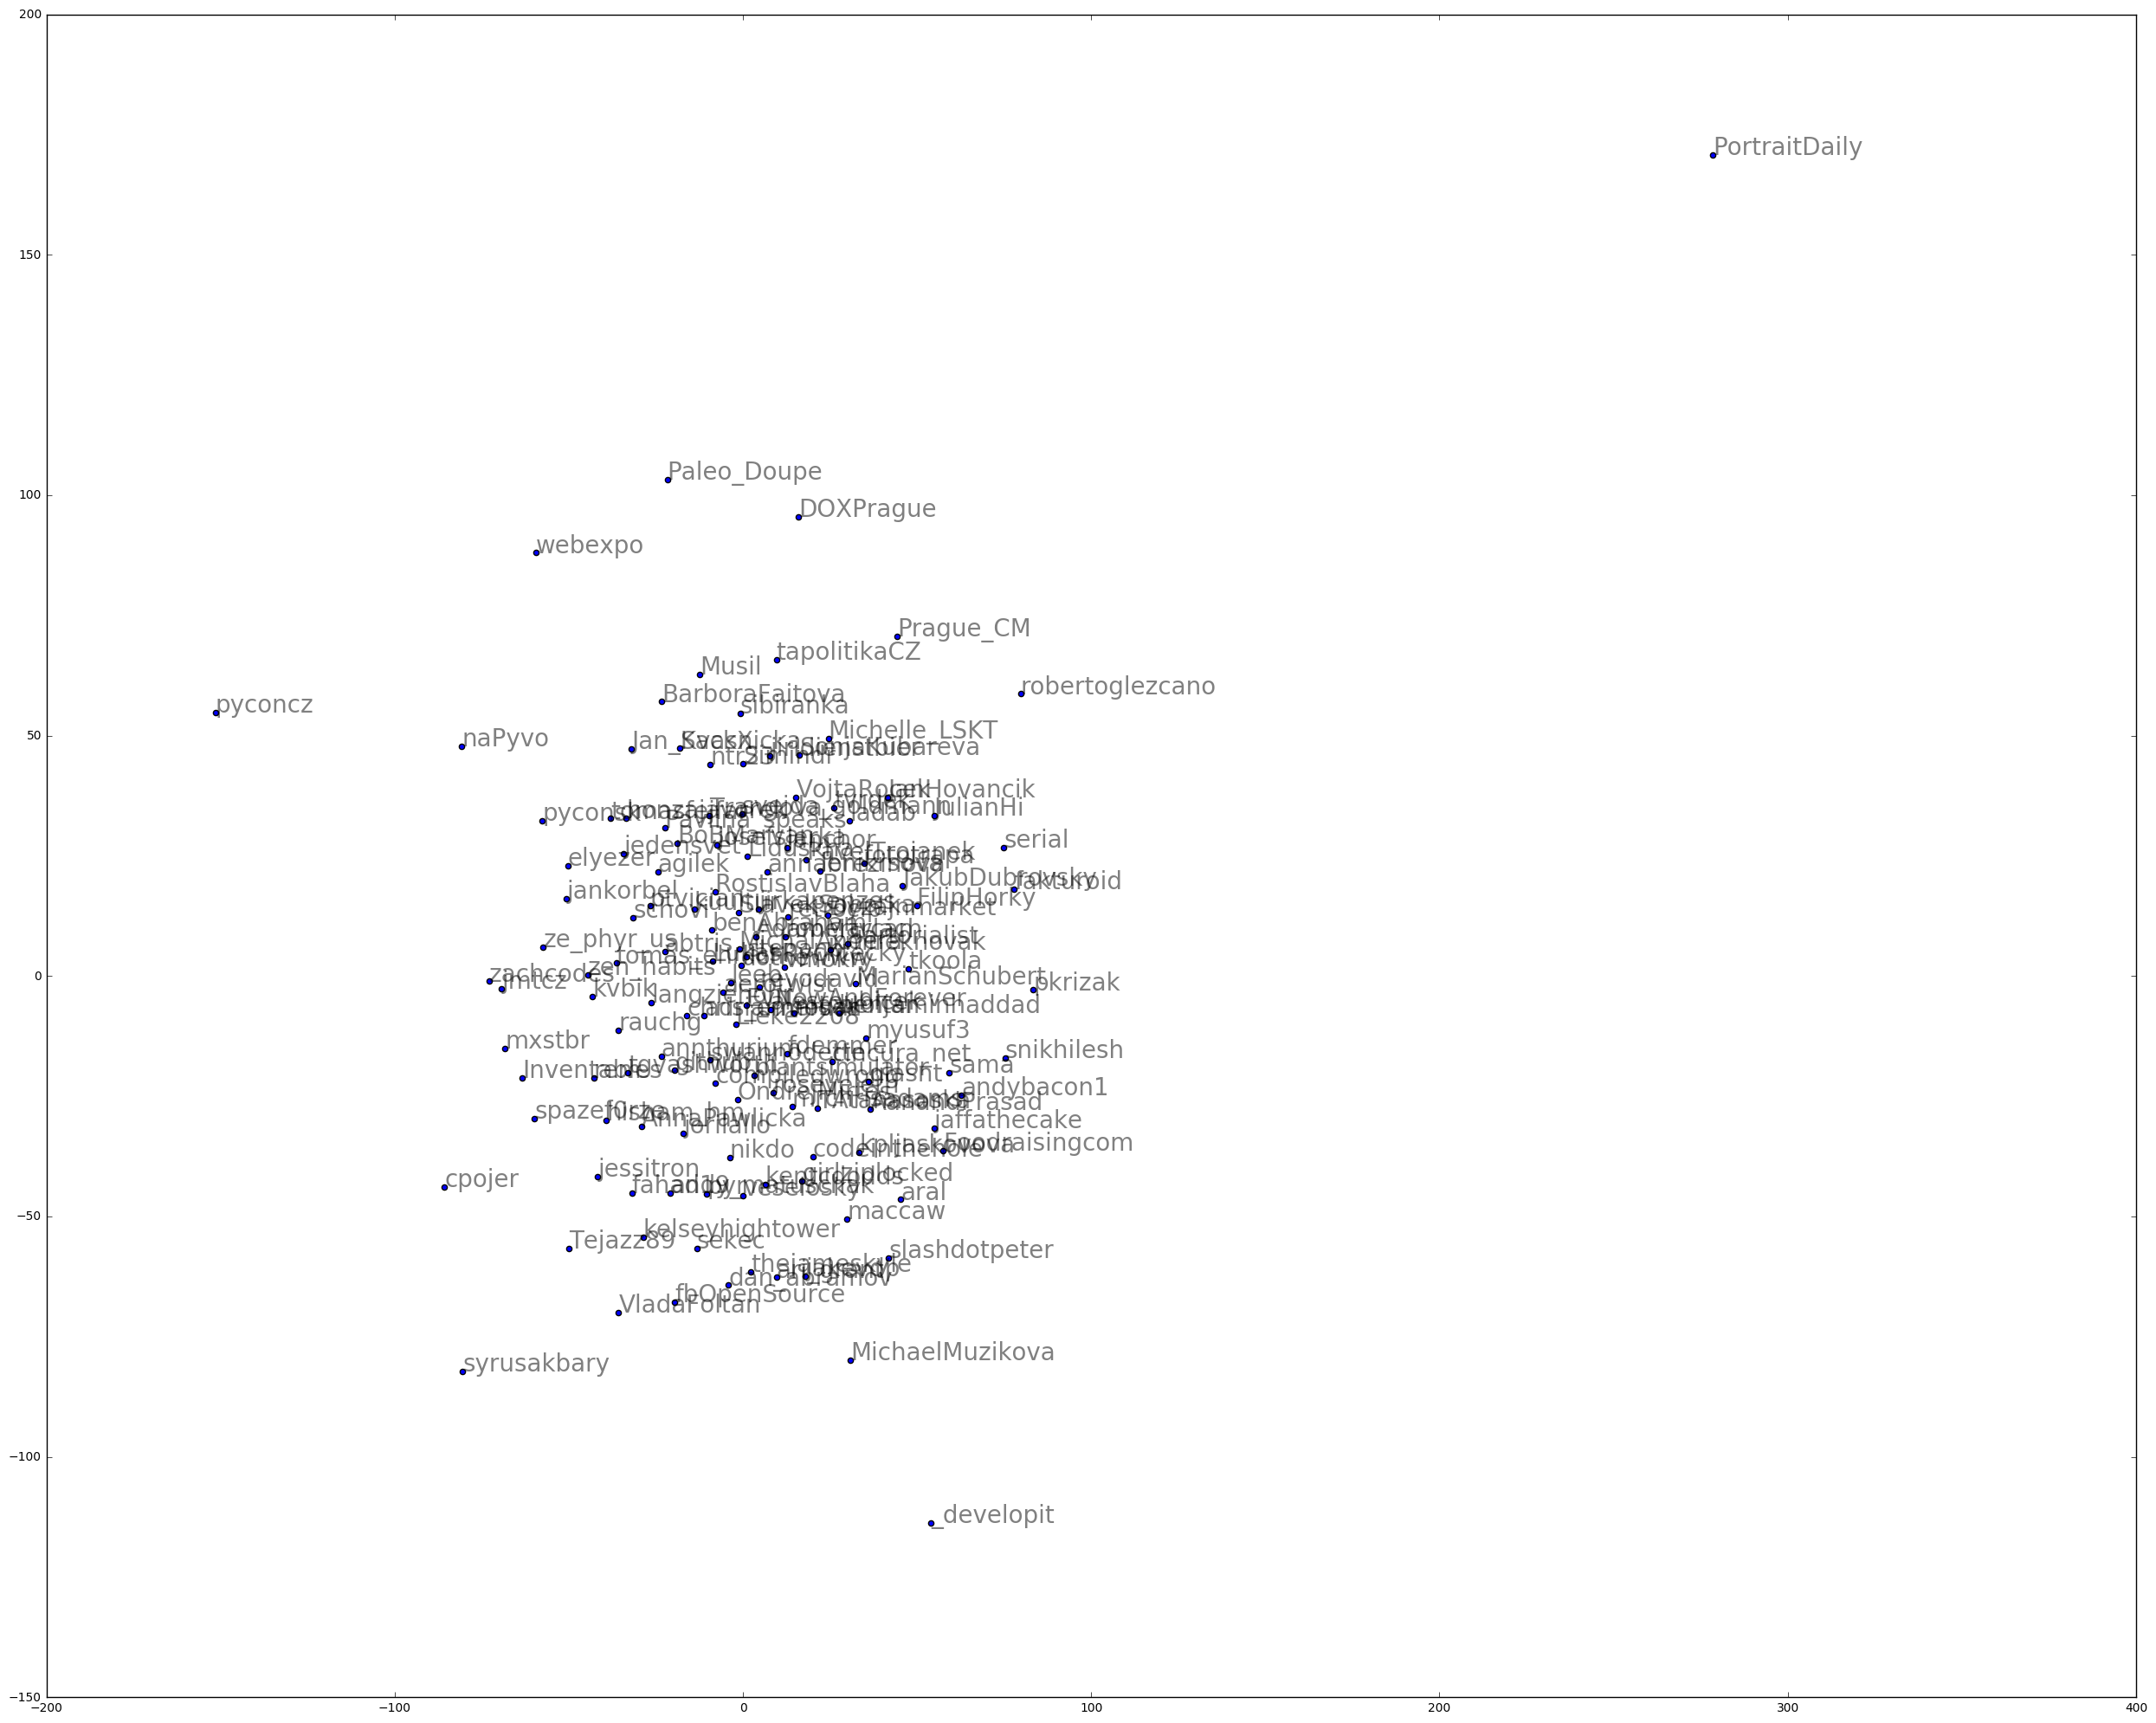

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=1)
pos = mds.fit_transform(dtm)  # shape (n_components, n_samples)

plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]

plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    if name == 'josefrousek':
        plt.text(x, y, name, alpha=0.5, fontsize=30)
    else:
        plt.text(x, y, name, alpha=0.5, fontsize=20)


plt.tight_layout() 

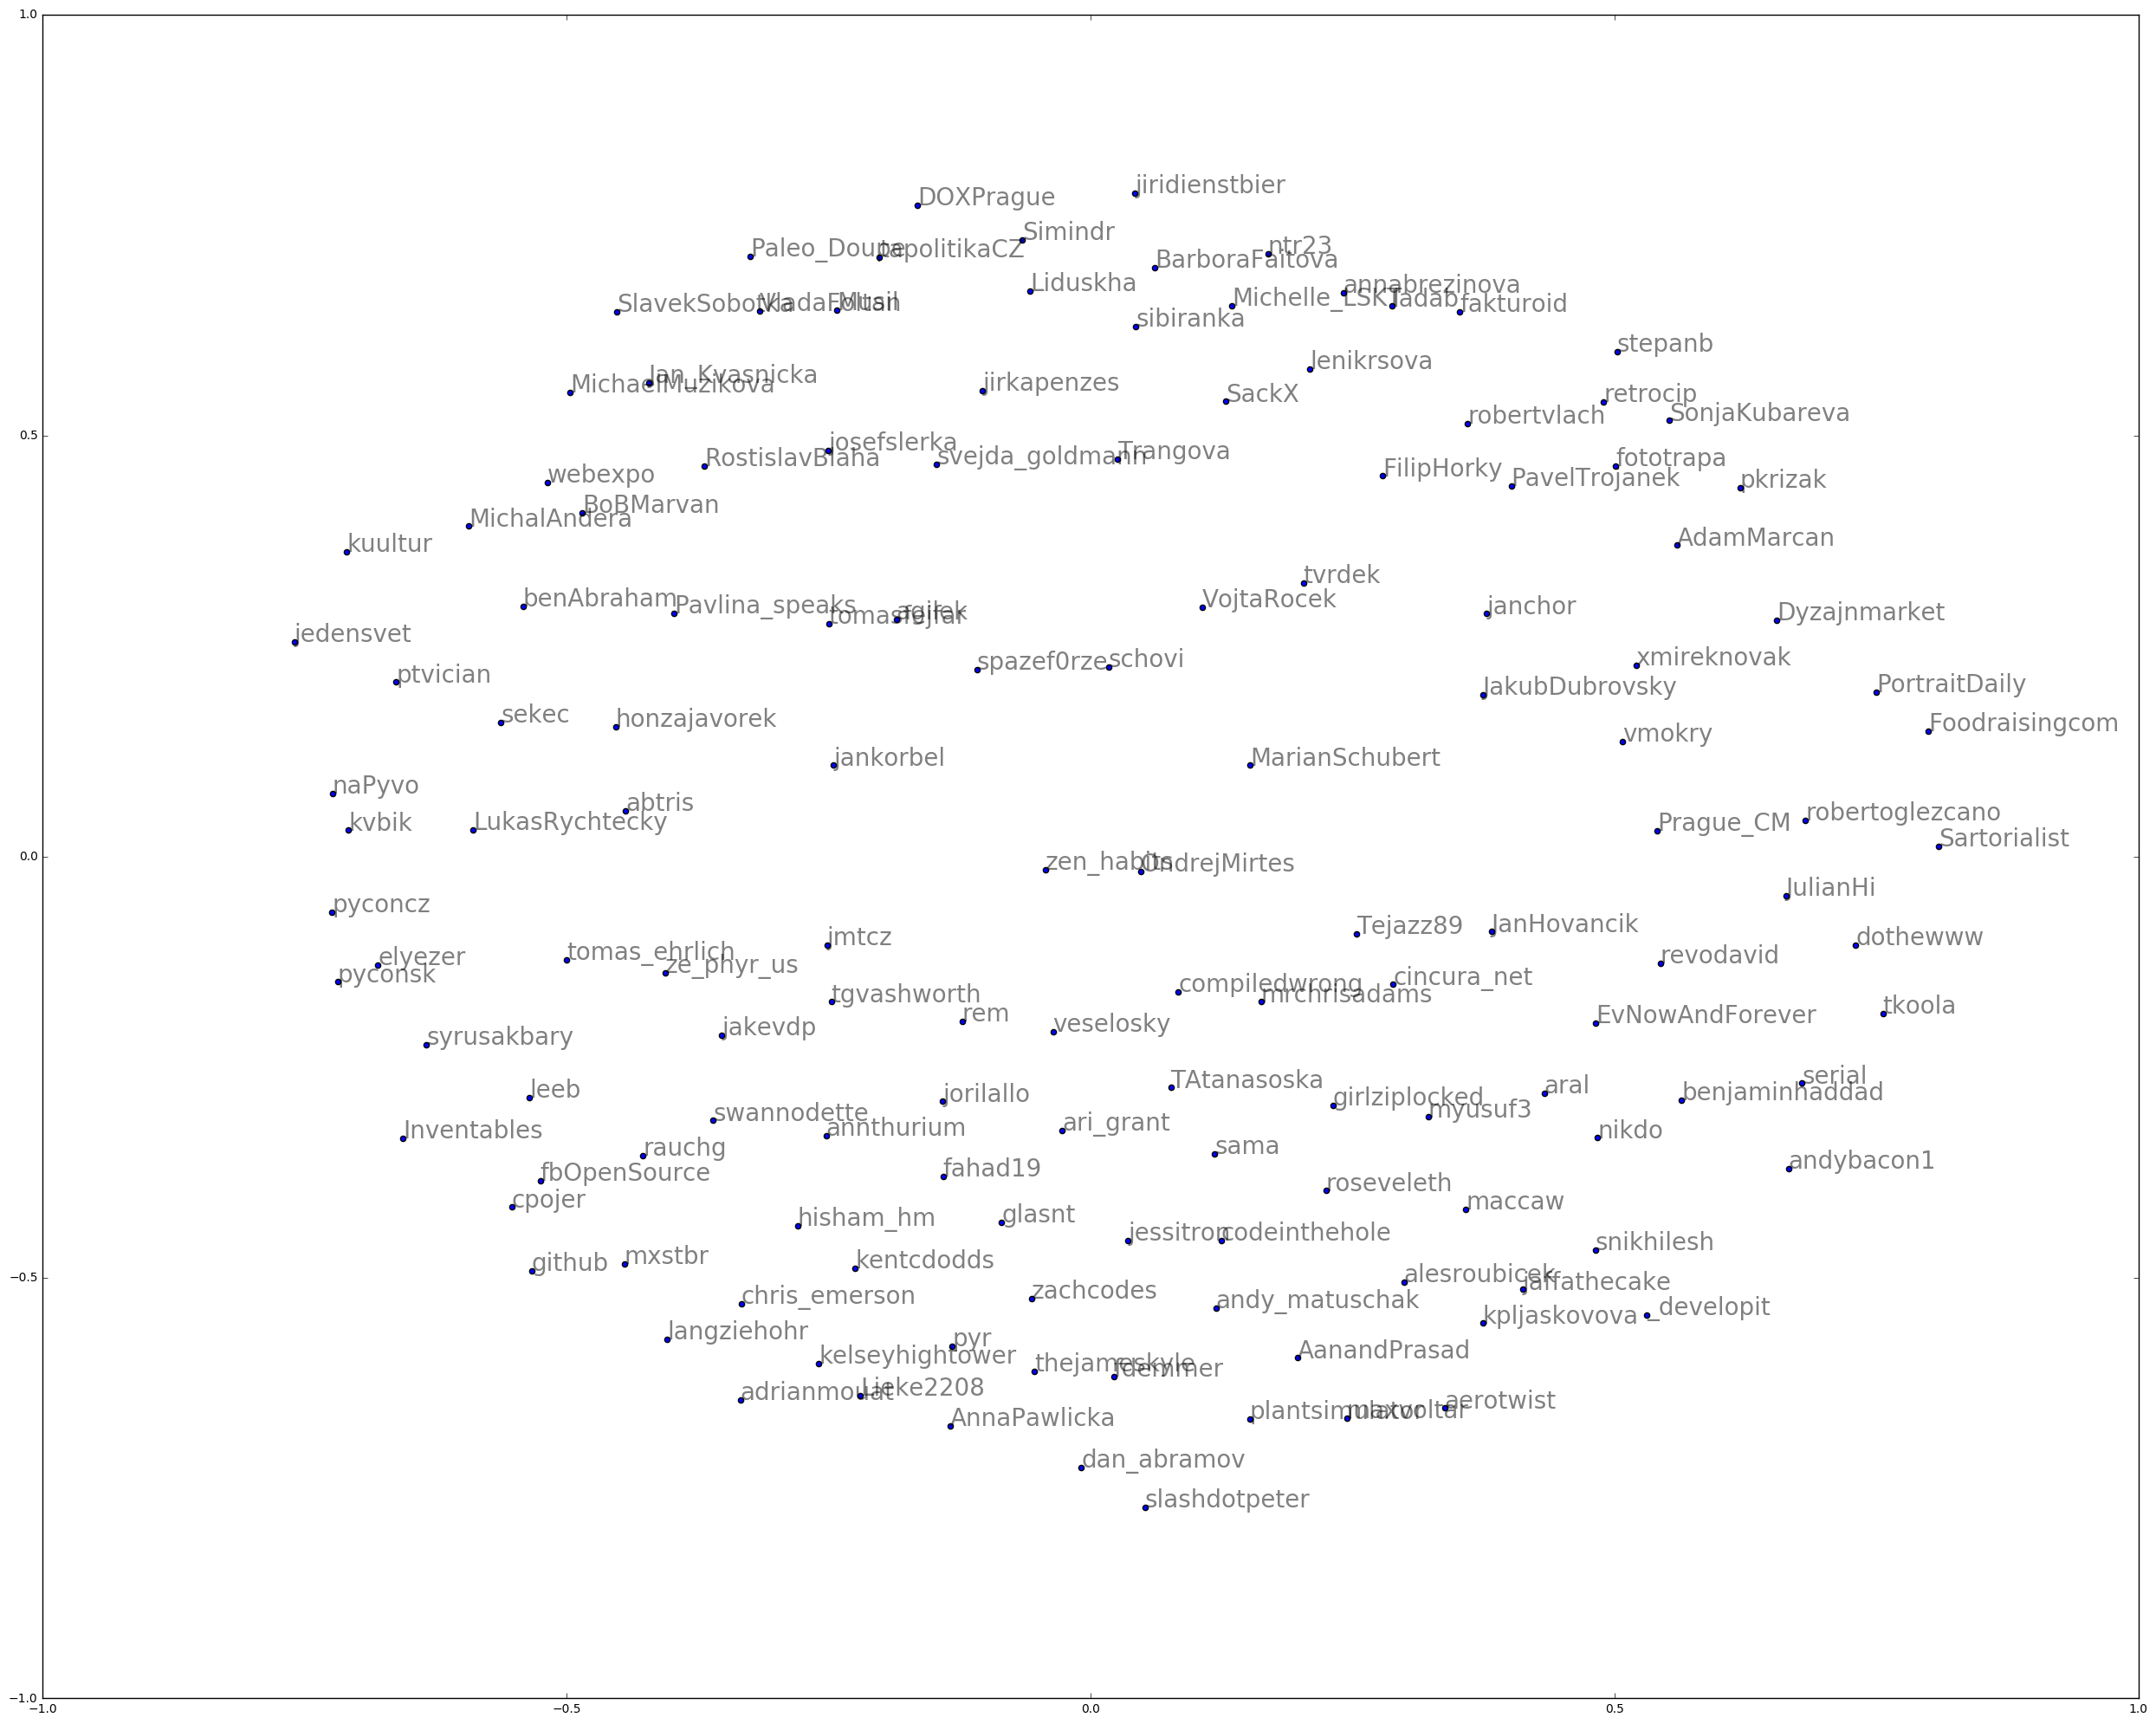

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)


plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

# plt.xkcd()
plt.tight_layout()

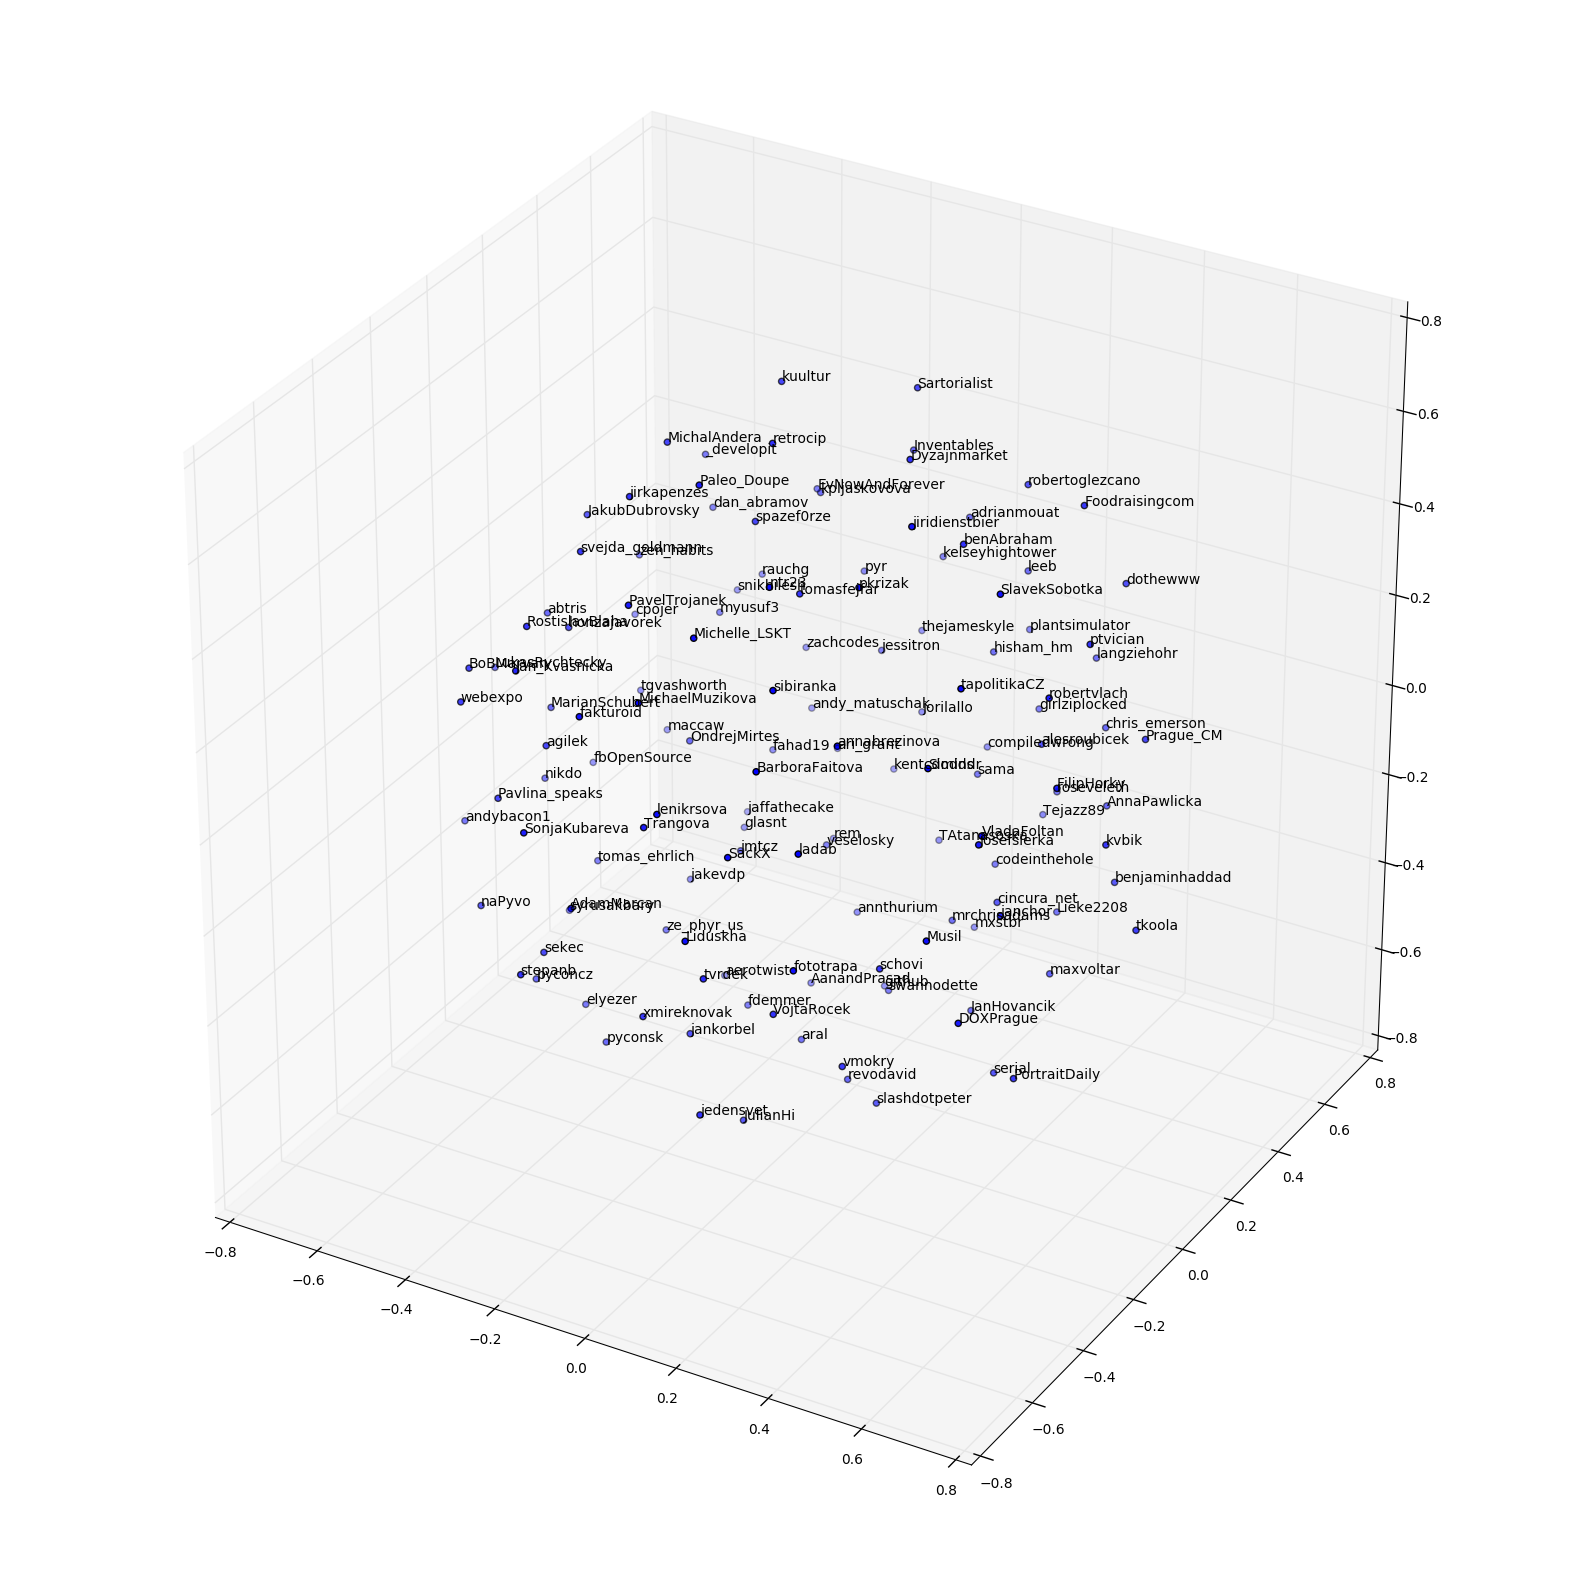

In [6]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))  # use a bigger canvas than usual

ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], usernames):
    ax.text(x, y, z, s)

plt.show()

### Actual distances we can work with

In [7]:
distances = euclidean_distances(dtm)
users_with_distance = [(user, distances[usernames.index('josefrousek'), usernames.index(user)]) for user in usernames]
users_with_distance.sort(key=lambda user: user[1])

pd.set_option('display.max_rows', 200) 
pd.DataFrame(users_with_distance)

ValueError: 'josefrousek' is not in list